## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Handling data 

In [2]:
data=pd.read_csv('fer2013.csv')

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
def getarrays(balance_ones=True):
    Y = []
    X = []
    first = True
    for line in open('fer2013.csv'):
        if first:
            first = False#moves to the second row
        else:
            row = line.split(',')#splits each element of string by comma
            Y.append(int(row[0]))#appends each element of emotion to y as integer
            X.append([int(p) for p in row[1].split()])#splits and appends each element of pixels to x

    X, Y = np.array(X) / 255.0, np.array(Y)#divided by maximum pixel to normalize
    X, Y = shuffle(X, Y)
    Xtrain, Ytrain = X[:-1000], Y[:-1000]
    Xvalid, Yvalid = X[-1000:], Y[-1000:]
    if balance_ones:
        # balance the 1 class
        X0, Y0 = Xtrain[Ytrain!=1, :], Ytrain[Ytrain!=1]
        X1 = Xtrain[Ytrain==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        Xtrain = np.vstack([X0, X1])
        Ytrain = np.concatenate((Y0, [1]*len(X1)))

    return Xtrain, Ytrain, Xvalid, Yvalid

## Plotting image

In [5]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
def showimages():
    X, Y,Xv,Yv = getarrays()##gets 4 arrays from getarray fun
    while True:
        for i in range(7):
            x, y = X[Y==i], Y[Y==i]#x ,y according to the label for example 0 is anger X[Y==0] gives pixels of angry image.
            N = len(y)#number of times where y is i
            j = np.random.choice(N)#randomly chooses any y
            plt.imshow(x[j].reshape(48, 48), cmap='gray')#plots that random image
            plt.title(label_map[y[j]])
            plt.show()
        message = input('Quit? Enter Y:\n')
        if message.lower().startswith('y'):
            break

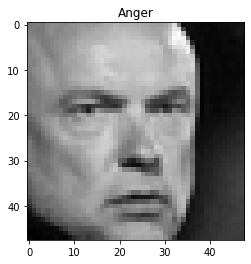

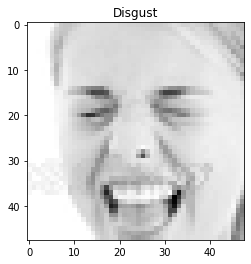

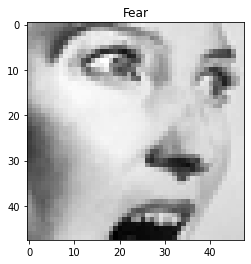

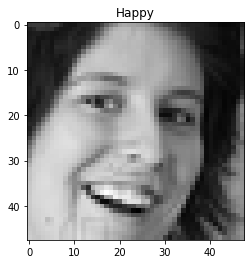

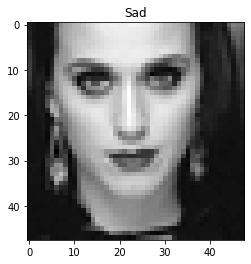

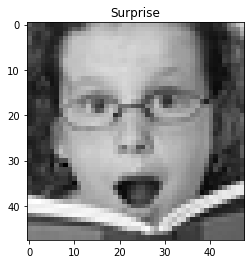

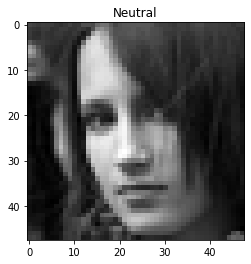

Quit? Enter Y:
y


In [7]:
showimages()

## Implementing important functions

In [8]:
def one_hot_encode(y):
    N = len(y)
    K = len(set(y))# k is 7 because there are 7 types of outputs
    ind = np.zeros((N, K))#creating zeros arrays for size N,7 
    for i in range(N):
        ind[i, y[i]] = 1
    return ind 

In [9]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

In [10]:
def cost(T, Y):
    return -(T*np.log(Y)).sum()

In [11]:
def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    return -np.log(Y[np.arange(N), T]).mean()

In [12]:
def error_rate(targets, predictions):
    return np.mean(targets != predictions)#measures the differnce btw what model predicts vs actual value

## Training Model

In [17]:
class ANN(object):
    def __init__(self, M):
        self.M = M# creats object

    def fit(self, X, Y, Xvalid, Yvalid, learning_rate=1e-6, reg=1e-6, epochs=1000, show_fig=False):
        #epochs iteration of two data points 
        N, D = X.shape
        K = len(set(Y))
        T = one_hot_encode(Y)
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)## shape of W1(2304,200)
        self.b1 = np.zeros(self.M)## shape of b1(200)
        self.W2 = np.random.randn(self.M, K) / np.sqrt(self.M)#shape of W2(200,7)
        self.b2 = np.zeros(K)## shape of b2(7)

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY, Z = self.forward(X)## feed foward step

            # gradient descent step
            pY_T = pY - T# temporary val-actual val(dZ2=A2-T)
            #backpropagation step
            self.W2 -= learning_rate*(Z.T.dot(pY_T) + reg*self.W2)#w2-alpha(dw2)
            self.b2 -= learning_rate*(pY_T.sum(axis=0) + reg*self.b2)#summation(dZ2)
            # dZ = pY_T.dot(self.W2.T) * (Z > 0) # relu
            dZ = pY_T.dot(self.W2.T) * (1 - Z*Z) # tanh(dZ1=W2*dZ2*derivative_of_activationfunc(Z1))
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1)#w1-alpha(dw1)=1/m*dz1*XT
            self.b1 -= learning_rate*(dZ.sum(axis=0) + reg*self.b1)#summation(dZ1)

            if i % 100 == 0:
                pYvalid, _ = self.forward(Xvalid)#testing of model takes in test data
                c = cost2(Yvalid, pYvalid)#goes through cost function to measure of errors
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))#calculates error rates
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        # Z = relu(X.dot(self.W1) + self.b1)
        Z = np.tanh(X.dot(self.W1) + self.b1)##W1.X+b1 through activation function Z1 i.e tanh
        return softmax(Z.dot(self.W2) + self.b2), Z##W2*(Z1)+b2 through softmax

    def predict(self, X):
        pY, _ = self.forward(X)
        return np.argmax(pY, axis=1)#returns max of array

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

## Model fitting

In [18]:
def fit_model():
    Xtrain, Ytrain, Xvalid, Yvalid = getarrays()    
    model = ANN(200)
    model.fit(Xtrain, Ytrain, Xvalid, Yvalid, reg=0, show_fig=True)
    print(model.score(Xvalid, Yvalid))

## Result

i: 0 cost: 2.0466644641157954 error: 0.785
i: 100 cost: 1.8415890936326427 error: 0.76
i: 200 cost: 1.8034526642435527 error: 0.689
i: 300 cost: 1.751329241591884 error: 0.666
i: 400 cost: 1.7348889702848844 error: 0.687
i: 500 cost: 1.7698239438881886 error: 0.692
i: 600 cost: 1.780293783826177 error: 0.702
i: 700 cost: 1.71282260149102 error: 0.645
i: 800 cost: 1.7779419176520974 error: 0.702
i: 900 cost: 1.7593541368667212 error: 0.683
best_validation_error: 0.645


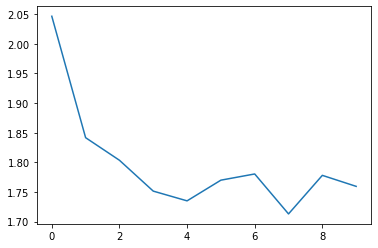

0.32599999999999996


In [19]:
fit_model()